<a href="https://colab.research.google.com/github/khanh22mse23057/python4engineer-assignments/blob/main/Assignments3_M5_Forecasting_with_LSTM_and_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tìm hiểu về LSTM and LightGBM

##  *Lời mở đầu*

Long short-term memory (LSTM) là một kiến ​​trúc artificial recurrent neural network (RNN) được sử dụng trong lĩnh vực Deep learning. 

Light gradient-boost machine(LightGBM), là một khuôn khổ tăng cường độ dốc phân tán miễn phí và mã nguồn mở dành cho máy học, ban đầu được phát triển bởi Microsoft. Nó dựa trên các thuật toán cây quyết định và được sử dụng để xếp hạng, phân loại và các tác vụ học máy khác


### **Cài đặt môi trường**
Để truy xuất được dữ liệu từ Kaggle cũng như chạy được các đoạn mã ví dụ cần phải cài đặt một số packages

In [ ]:
# Một số functions trong bài không work với latest version, nên cài đặt packages version chỉ định như sau
!pip install opendatasets
# !pip install pandas==1.2.0
# !pip install pystan==3.0.0
!pip install pandas 

!pip install kaggle
!pip install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1319 sha256=71205b29e3035301c7629956f4da7c9e64709dd2ca82288ca60f805810a3976c
  Stored in directory: /root/.cache/pip/wheels/c5/05/b3/f7b36dbaaf76de31b718cde792c953bfd11d2414a72f204b56
Successfully built unzip



### Tải tệp dữ liệu training từ Kaggle
Để truy cập được tệp data từ Kaggle, cần phải tạo key và cấu hình môi trường

Ví dụ file secret key được tạo từ Kaggle và được lấy về từ github. Cách tạo key : https://prnt.sc/UCwb6zgoPzYT
* Lưu ý: Kaggle yêu cầu xác thực tài khoản bằng số điện thoại để cấp cấp quyền truy cập dữ liệu.

In [ ]:
import os
#Cấu hình secret key để xác thực truy cập đến Kaggle trên môi trường
os.environ['KAGGLE_USERNAME'] = 'khanhphamnguyenphu'
os.environ['KAGGLE_KEY'] = '67b96e181bd01730f8e8ec3cf2b685a7'

!if [ -d ~/.kaggle/ ]; then rm -Rf ~/.kaggle/; fi
!if [ -d ./kaggle/input/ ]; then rm -Rf ./kaggle/input/; fi

!kaggle competitions download -c m5-forecasting-accuracy -p ./kaggle/input/ # Download dữ liệu train từ Kaggle
!unzip  ./kaggle/input/*.zip -d ./kaggle/input/
!ls ./kaggle/input/ 


 79% 36.0M/45.8M [00:00<00:00, 82.9MB/s]
100% 45.8M/45.8M [00:00<00:00, 85.6MB/s]
Archive:  ./kaggle/input/m5-forecasting-accuracy.zip
  inflating: ./kaggle/input/calendar.csv  
  inflating: ./kaggle/input/sales_train_evaluation.csv  
  inflating: ./kaggle/input/sales_train_validation.csv  
  inflating: ./kaggle/input/sample_submission.csv  
  inflating: ./kaggle/input/sell_prices.csv  
calendar.csv		     sales_train_evaluation.csv  sample_submission.csv
m5-forecasting-accuracy.zip  sales_train_validation.csv  sell_prices.csv


# Import dữ liệu và thư viện

In [ ]:
# importing all necessary libraries
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tqdm.notebook import tqdm as tqdm

import plotly.graph_objs as go #visualization library
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation test
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationarity test
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from datetime import datetime, timedelta
import statsmodels.api as sm
import gc
from pylab import rcParams
import random
import os
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc
import lightgbm as lgb
import time
import numpy as np
import pandas as pd
import os
import time
import matplotlib.dates as mdates
import gc
import lightgbm as lgb
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Kiểm tra dữ liệu input

In [ ]:
# Đọc dữ liệu từ file csv vào data frame
calender = pd.read_csv('/content/kaggle/input/calendar.csv')
train_sales = pd.read_csv('/content/kaggle/input/sales_train_evaluation.csv')
df_val = pd.read_csv('/content/kaggle/input/sales_train_validation.csv')
sell_prices = pd.read_csv('/content/kaggle/input/sell_prices.csv')

# check data completely 
print('-----------------------------train_sales--------------------------------------')
train_sales.info()
print('-----------------------------calender--------------------------------------')
calender.info()
print('-----------------------------sell_prices--------------------------------------')
sell_prices.info()


-----------------------------train_sales--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB
-----------------------------calender--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 n

In [ ]:
print('------------- 5 rows of train_sales --------------')
train_sales.head()

------------- 5 rows of train_sales --------------


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
# print first 5 rows of calendar
print('------------- 5 first rows of calendar --------------')
calender.head()

------------- 5 rows of calendar --------------


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
# print first 5 rows of sell_prices
print('------------- 5 first rows of sell_prices --------------')
sell_prices.head()

------------- 5 first rows of sell_prices --------------


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Khám phá dữ liệu

## Kiểm tra giá trị NULL trên dữ liệu input

In [ ]:
#Kiểm tra và hiện thị thông tin dữ liệu NULL trên tệp train_sales data
train_sales.isnull().sum().sort_values(ascending = False)

id        0
d_1273    0
d_1301    0
d_1300    0
d_1299    0
         ..
d_639     0
d_638     0
d_637     0
d_636     0
d_1941    0
Length: 1947, dtype: int64

In [ ]:
##Kiểm tra và hiện thị thông tin dữ liệu NULL trên tệp sell_prices data
sell_prices.isnull().sum().sort_values(ascending = False)

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [ ]:
#Kiểm tra và hiện thị thông tin dữ liệu NULL trên tệp calender data
calender.isnull().sum().sort_values(ascending = False)

event_name_2    1964
event_type_2    1964
event_name_1    1807
event_type_1    1807
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [ ]:
holiday = ['NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'SuperBowl', 'PresidentsDay', 'StPatricksDay', 'Easter', 'Cinco De Mayo', 'IndependenceDay', 'EidAlAdha', 'Thanksgiving', 'Christmas']
weekend = ['Saturday', 'Sunday']

def is_holiday(x): #Hàm kiểu tra trả về true/fasle nếu là ngày lễ/nghỉ
    if x in holiday:
        return 1
    else:
        return 0

def is_weekend(x): #Hàm kiểu tra trả về true/fasle nếu là ngày cuối tuần
    if x in weekend:
        return 1
    else:
        return 0
# Tiền xử lý dữ liệu trên tệp calendar đầu vào
# Thêm các cột dữ liệu thông tin kiểm tra sự kiện của giá trị các ngày event : là holiday hoặc ngày cuối tuần
calender['is_holiday_1'] = calender['event_name_1'].apply(is_holiday)
calender['is_holiday_2'] = calender['event_name_2'].apply(is_holiday)
calender['is_holiday'] = calender[['is_holiday_1','is_holiday_2']].max(axis=1)
calender['is_weekend'] = calender['weekday'].apply(is_weekend)       

In [ ]:
# print first 5 rows
calender.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_holiday_1,is_holiday_2,is_holiday,is_weekend
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0


In [ ]:
#Tinh giảm các dữ liệu trong tệp calender
calender = calender.drop(['weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], axis='columns')

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [ ]:
# Thông kế tóm tắt dữ liệu trong tệp sell_prices
sell_prices.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [ ]:
del_col = []
for x in range(1851):
    del_col.append('d_' + str(x+1))
train_sales =train_sales.drop(del_col, axis='columns')

## Join các bảng dữ liệu và đánh giá

In [ ]:
#join eval and cal and price

train_sales = train_sales.melt(['id','item_id','dept_id','cat_id','store_id','state_id'], var_name='d', value_name='qty')
print(train_sales.shape)
train_sales.head()

(2744100, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,qty
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,1
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0


In [ ]:
train_sales = pd.merge(train_sales, calender, how='left', on='d')
train_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,qty,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,is_holiday_1,is_holiday_2,is_holiday,is_weekend
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,1,2016-02-23,11604,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0


In [ ]:
train_sales = pd.merge(train_sales, sell_prices, how='left', on=['item_id', 'wm_yr_wk', 'store_id'])
train_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,qty,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,is_holiday_1,is_holiday_2,is_holiday,is_weekend,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,8.26
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,3.97
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,2.97
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,1,2016-02-23,11604,0,0,0,0,0,0,0,4.64
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,2.88


In [ ]:
#print shape of the dataset 
train_sales.shape

(2744100, 18)

In [ ]:
train_sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,qty,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,is_holiday_1,is_holiday_2,is_holiday,is_weekend,sell_price
2744095,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,0,0,0,0,0,0,1,2.98
2744096,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,0,0,0,0,0,0,1,2.48
2744097,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,0,0,0,0,0,0,1,3.98
2744098,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,0,0,0,0,0,0,1,1.28
2744099,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,0,0,0,0,0,0,1,1.00


In [ ]:
train_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,qty,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,is_holiday_1,is_holiday_2,is_holiday,is_weekend,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,8.26
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,3.97
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,2.97
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,1,2016-02-23,11604,0,0,0,0,0,0,0,4.64
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,2.88


In [ ]:
train_sales_test = train_sales.query('d == "d_1852"')
train_sales_test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,qty,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,is_holiday_1,is_holiday_2,is_holiday,is_weekend,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,8.26
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,3.97
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,2.97
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,1,2016-02-23,11604,0,0,0,0,0,0,0,4.64
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1852,0,2016-02-23,11604,0,0,0,0,0,0,0,2.88


In [ ]:
train_sales_test = train_sales_test[['id', 'store_id', 'item_id', 'dept_id', 'cat_id', 'state_id', 'd', 'qty', 'sell_price']]
train_sales_test.head()

,id,store_id,item_id,dept_id,cat_id,state_id,d,qty,sell_price
0,HOBBIES_1_001_CA_1_evaluation,CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA,d_1852,0,8.26
1,HOBBIES_1_002_CA_1_evaluation,CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA,d_1852,0,3.97
2,HOBBIES_1_003_CA_1_evaluation,CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA,d_1852,0,2.97
3,HOBBIES_1_004_CA_1_evaluation,CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA,d_1852,1,4.64
4,HOBBIES_1_005_CA_1_evaluation,CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA,d_1852,0,2.88


In [ ]:
train_sales_test.shape

(30490, 9)

In [ ]:
train_sales_test['qty'] =train_sales_test['d'].apply(lambda x: int(x.replace(x, '0')))
tmp_df =train_sales_test

for x in range(28):
    train_sales_test =train_sales_test.append(tmp_df)

train_sales_test =train_sales_test.reset_index(drop=True)

train_sales_test.tail()

,id,store_id,item_id,dept_id,cat_id,state_id,d,qty,sell_price
884205,FOODS_3_823_WI_3_evaluation,WI_3,FOODS_3_823,FOODS_3,FOODS,WI,d_1852,0,2.88
884206,FOODS_3_824_WI_3_evaluation,WI_3,FOODS_3_824,FOODS_3,FOODS,WI,d_1852,0,2.00
884207,FOODS_3_825_WI_3_evaluation,WI_3,FOODS_3_825,FOODS_3,FOODS,WI,d_1852,0,3.98
884208,FOODS_3_826_WI_3_evaluation,WI_3,FOODS_3_826,FOODS_3,FOODS,WI,d_1852,0,1.28
884209,FOODS_3_827_WI_3_evaluation,WI_3,FOODS_3_827,FOODS_3,FOODS,WI,d_1852,0,1.00


In [ ]:
lst_d = []
i = 0
lst_index = train_sales_test.index
for x in lst_index:
    lst_d.append('d_' + str(((lst_index[i]) // 30490) + 1942))
    i = i + 1

lst_d

['d_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',
 'd_1942',

In [ ]:
train_sales_test['d'] = lst_d
train_sales_test.head()

,id,store_id,item_id,dept_id,cat_id,state_id,d,qty,sell_price
0,HOBBIES_1_001_CA_1_evaluation,CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA,d_1942,0,8.26
1,HOBBIES_1_002_CA_1_evaluation,CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA,d_1942,0,3.97
2,HOBBIES_1_003_CA_1_evaluation,CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA,d_1942,0,2.97
3,HOBBIES_1_004_CA_1_evaluation,CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA,d_1942,0,4.64
4,HOBBIES_1_005_CA_1_evaluation,CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA,d_1942,0,2.88


In [ ]:
# print last 5 rows in dataset
train_sales_test.tail()

,id,store_id,item_id,dept_id,cat_id,state_id,d,qty,sell_price
884205,FOODS_3_823_WI_3_evaluation,WI_3,FOODS_3_823,FOODS_3,FOODS,WI,d_1970,0,2.88
884206,FOODS_3_824_WI_3_evaluation,WI_3,FOODS_3_824,FOODS_3,FOODS,WI,d_1970,0,2.00
884207,FOODS_3_825_WI_3_evaluation,WI_3,FOODS_3_825,FOODS_3,FOODS,WI,d_1970,0,3.98
884208,FOODS_3_826_WI_3_evaluation,WI_3,FOODS_3_826,FOODS_3,FOODS,WI,d_1970,0,1.28
884209,FOODS_3_827_WI_3_evaluation,WI_3,FOODS_3_827,FOODS_3,FOODS,WI,d_1970,0,1.00


In [ ]:
# shape of dataset
train_sales_test.shape

(884210, 9)

In [ ]:
train_sales_test = pd.merge(train_sales_test,calender, how='left', on='d')


In [ ]:
train_sales_test = pd.merge(train_sales_test, sell_prices ,how='left', on=['item_id', 'wm_yr_wk', 'store_id'])


KeyError: ignored

In [ ]:
train_sales_test.head()

,id,item_id,d,qty,date_x,wm_yr_wk_x,is_holiday_1_x,is_holiday_2_x,is_holiday_x,is_weekend_x,...,state_id_WI,date_y,wm_yr_wk_y,snap_CA,snap_TX,snap_WI,is_holiday_1_y,is_holiday_2_y,is_holiday_y,is_weekend_y
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,d_1942,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,...,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,d_1942,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,...,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,d_1942,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,...,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,d_1942,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,...,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,d_1942,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,...,0,2016-05-23,11617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Xử lý và phân tích dữ liệu

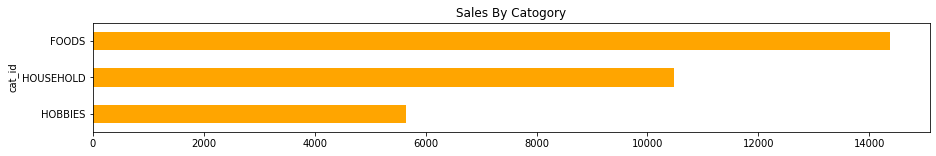

In [ ]:
#Sales Catogery
df_val.groupby('cat_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,2), title='Sales By Catogory',width=0.5,color='orange')
plt.show()

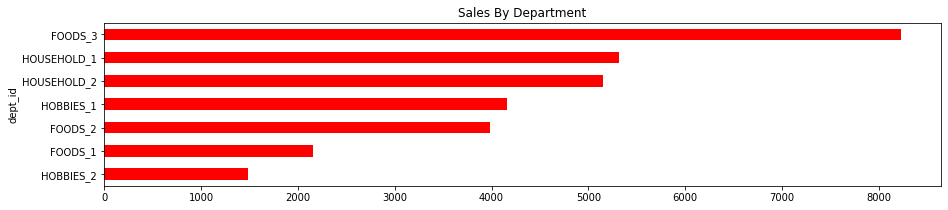

In [ ]:
#Sales By Department
df_val.groupby('dept_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,3), title='Sales By Department',color='red')
plt.show()

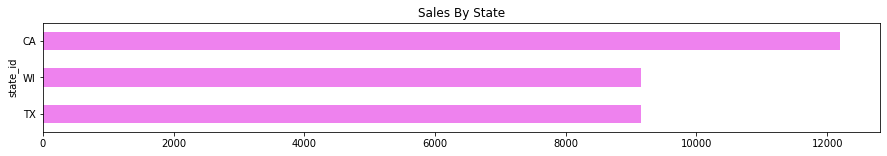

In [ ]:
#Sales By State
df_val.groupby('state_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,2), title='Sales By State',color='violet')
plt.show()

Text(0.5, 1.0, 'Count of classes')

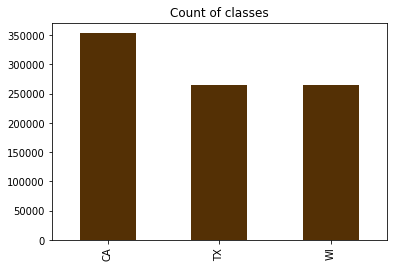

In [ ]:
pd.value_counts(train_sales_test['state_id']).plot(kind = 'bar',cmap = 'BrBG')
plt.rcParams['axes.facecolor'] = 'orange'
plt.title("Count of classes")

Text(0.5, 1.0, 'Count of classes')

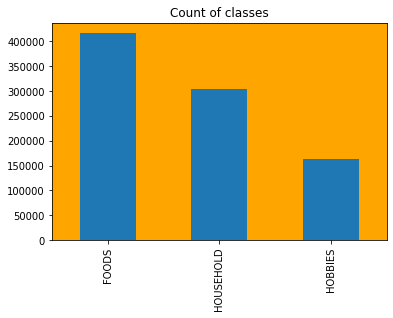

In [ ]:
pd.value_counts(train_sales_test['cat_id']).plot(kind = 'bar')
plt.rcParams['axes.facecolor'] = 'blue'
plt.title("Count of classes")

In [ ]:
ids = sorted(list(set(df_val['id'])))
d_cols = [c for c in df_val.columns if 'd_' in c]
x_1 = df_val.loc[df_val['id'] == ids[0]].set_index('id')[d_cols].values[0][:90]
x_2 = df_val.loc[df_val['id'] == ids[4]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = df_val.loc[df_val['id'] == ids[65]].set_index('id')[d_cols].values[0][350:450]
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="orange")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="red")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="violet")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

#### Rolling Average Price vs. Time for every store

In [ ]:

past_sales = df_val.set_index('id')[d_cols] \
    .T \
    .merge(calender.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = sell_prices['store_id'].unique()
means = []
fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)")


### Average sales vs. Store name

In [ ]:
df = pd.DataFrame(np.transpose([means, store_list]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Average sales vs. Store name")

Rolling Average Sales vs. Time (California)¶

In [ ]:
greens = ["mediumaquamarine", "orange", "red", "green"]
store_list = sell_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=greens[i])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")

### Mean sales vs. Store name (California)

In [ ]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : greens})])

fig.update_layout(title="Mean sales vs. Store name (California)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

### Rolling Average Sales vs. Time (Wisconsin)

In [ ]:
purples = ["red", "violet", "purple", "indigo"]
store_list = sell_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "wi" in s or "WI" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=purples[i%len(purples)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Wisconsin)")

### Mean sales vs. Store name (Wisconsin)

In [ ]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : purples})])

fig.update_layout(title="Mean sales vs. Store name (Wisconsin)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

In [ ]:
green = ["orange", "yellow", "seagreen"]
store_list = sell_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "tx" in s or "TX" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=green[i%len(green)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Texas)")

In [ ]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : green})])

fig.update_layout(title="Mean sales vs. Store name (Texas)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

## Observations

In [ ]:
import gc
del tmp_df
gc.collect()

7616

In [ ]:
train_sales = pd.get_dummies(data=train_sales, columns=['dept_id', 'cat_id', 'store_id', 'state_id'])
train_sales_test = pd.get_dummies(data=train_sales_test, columns=['dept_id', 'cat_id', 'store_id', 'state_id'])

KeyError: ignored

In [ ]:
train_sales_test.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010
d,d_1942,d_1942,d_1942,d_1942,d_1942,d_1942,d_1942,d_1942,d_1942,d_1942
qty,0,0,0,0,0,0,0,0,0,0
date_x,2016-05-23,2016-05-23,2016-05-23,2016-05-23,2016-05-23,2016-05-23,2016-05-23,2016-05-23,2016-05-23,2016-05-23
wm_yr_wk_x,11617.0,11617.0,11617.0,11617.0,11617.0,11617.0,11617.0,11617.0,11617.0,11617.0
is_holiday_1_x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_holiday_2_x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_holiday_x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is_weekend_x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_sales_test = train_sales_test.drop(['sell_price_x', 'snap_CA', 'snap_TX', 'snap_WI'], axis='columns')
train_sales_test = train_sales_test.rename(columns={'sell_price_y': 'sell_price'})
train_sales = train_sales.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis='columns')   

train_sales.info()

KeyError: ignored